In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from sqlalchemy import create_engine, MetaData, Table, select, and_
from sqlalchemy.orm import sessionmaker

In [2]:
# Conexión a la base de datos SQLite
DATABASE_PATH = "../mlruns.db"
engine = create_engine(f"sqlite:///{DATABASE_PATH}")

# Metadatos para acceder a las tablas
metadata = MetaData()
metadata.reflect(bind=engine)

# Referencias a las tablas
metrics = metadata.tables['metrics']
runs = metadata.tables['runs']
params = metadata.tables['params']




In [17]:
!pip install sqlite3

ERROR: Could not find a version that satisfies the requirement sqlite3 (from versions: none)
ERROR: No matching distribution found for sqlite3


In [8]:
# Consulta para obtener los datos
with engine.connect() as connection:
    query = (
        select(
            runs.c.run_uuid,
            runs.c.status,
            runs.c.experiment_id,
            runs.c.name.label("run_name"),
            metrics.c.key.label("metric_key"),
            metrics.c.value.label("metric_value"),
            metrics.c.step,
        )
        .select_from(
            metrics.join(runs, metrics.c.run_uuid == runs.c.run_uuid)
        )
        .where(
            and_(
                runs.c.name.like("latent%"),
                runs.c.status == "FINISHED"
            )
        )
    )
    result = connection.execute(query)
    data = result.fetchall()

# Convertir los resultados a un DataFrame de Pandas
df = pd.DataFrame(data, columns=result.keys())

# Visualizar el DataFrame
display(df.head())


,run_uuid,status,experiment_id,run_name,metric_key,metric_value,step
0,0360d77ee3cc4bbf96de3886c7ee868a,FINISHED,1,latent16,train_loss,0.164136,0
1,0360d77ee3cc4bbf96de3886c7ee868a,FINISHED,1,latent16,train_loss_loss,0.164136,0
2,0360d77ee3cc4bbf96de3886c7ee868a,FINISHED,1,latent16,train_ce_loss,640.395995,0
3,0360d77ee3cc4bbf96de3886c7ee868a,FINISHED,1,latent16,train_loss_ce_loss,640.395995,0
4,0360d77ee3cc4bbf96de3886c7ee868a,FINISHED,1,latent16,train_F1,0.730284,0


In [9]:
df.metric_key.unique()

array(['train_loss', 'train_loss_loss', 'train_ce_loss',
       'train_loss_ce_loss', 'train_F1', 'train_loss_F1',
       'train_Accuracy', 'train_loss_Accuracy', 'train_Accuracy_seq',
       'train_loss_Accuracy_seq', 'train_Precision',
       'train_loss_Precision', 'train_Recall', 'train_loss_Recall',
       'valid_loss_loss', 'valid_loss_ce_loss', 'valid_loss_F1',
       'valid_loss_Accuracy', 'valid_loss_Accuracy_seq',
       'valid_loss_Precision', 'valid_loss_Recall'], dtype=object)

In [10]:
df_ = df.query('metric_key in ["train_loss_loss", "valid_loss_loss"] & run_name not in ["latent2","latent4"]')

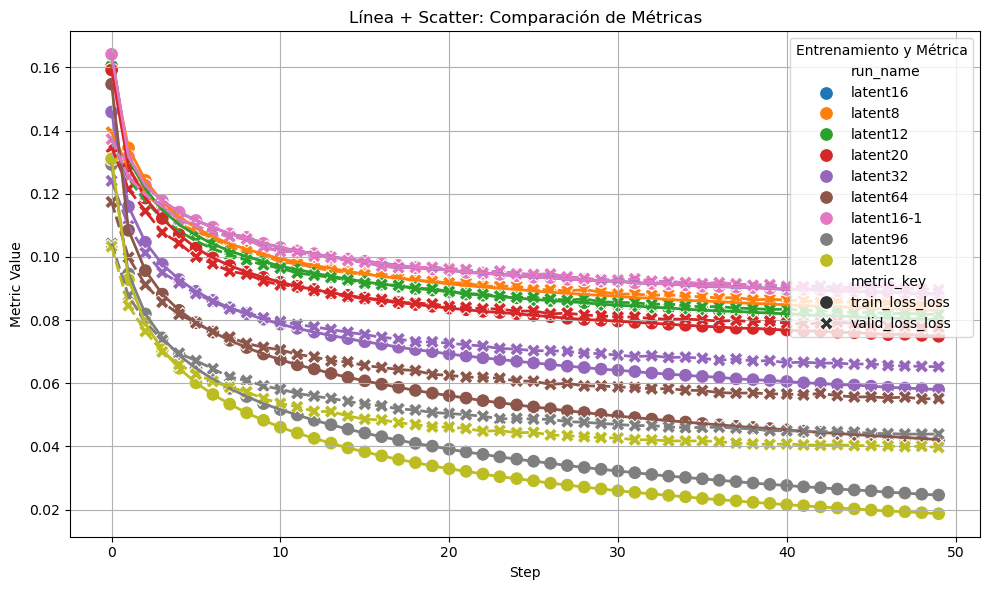

In [11]:
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df_,
    x="step",
    y="metric_value",
    hue="run_name",
    style="metric_key",
    palette="tab10",
    linewidth=2,
    legend=False
)
sns.scatterplot(
    data=df_,
    x="step",
    y="metric_value",
    hue="run_name",
    style="metric_key",
    palette="tab10",
    s=100
)
plt.title("Línea + Scatter: Comparación de Métricas")
plt.xlabel("Step")
plt.ylabel("Metric Value")
plt.legend(title="Entrenamiento y Métrica")
plt.grid(True)
plt.tight_layout()
plt.show()


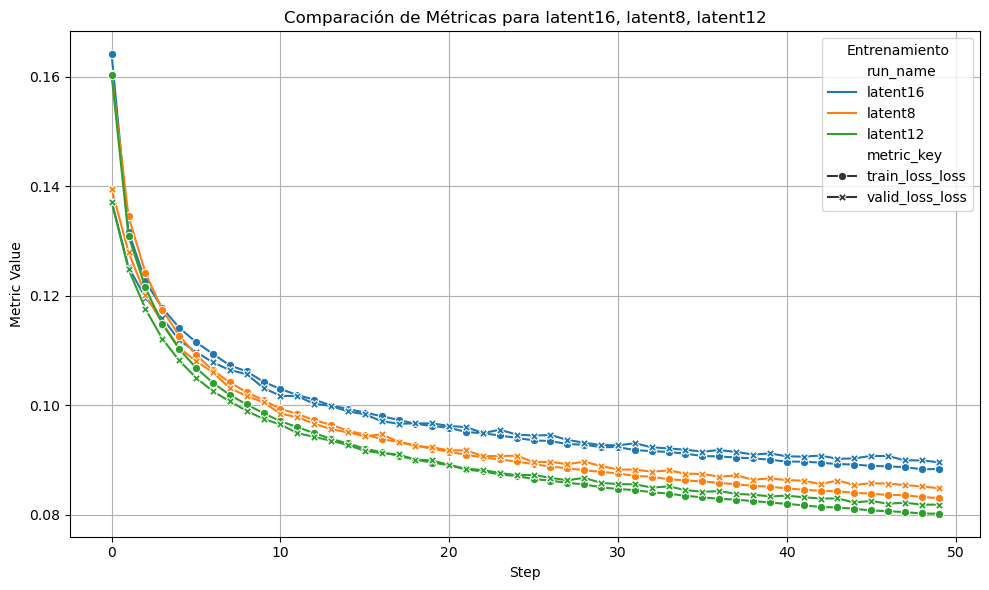

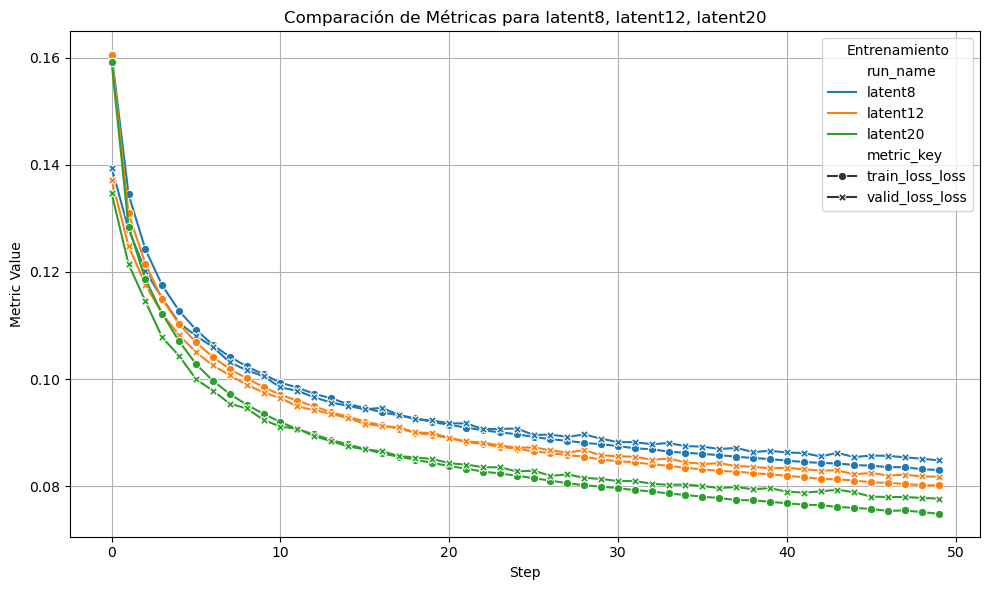

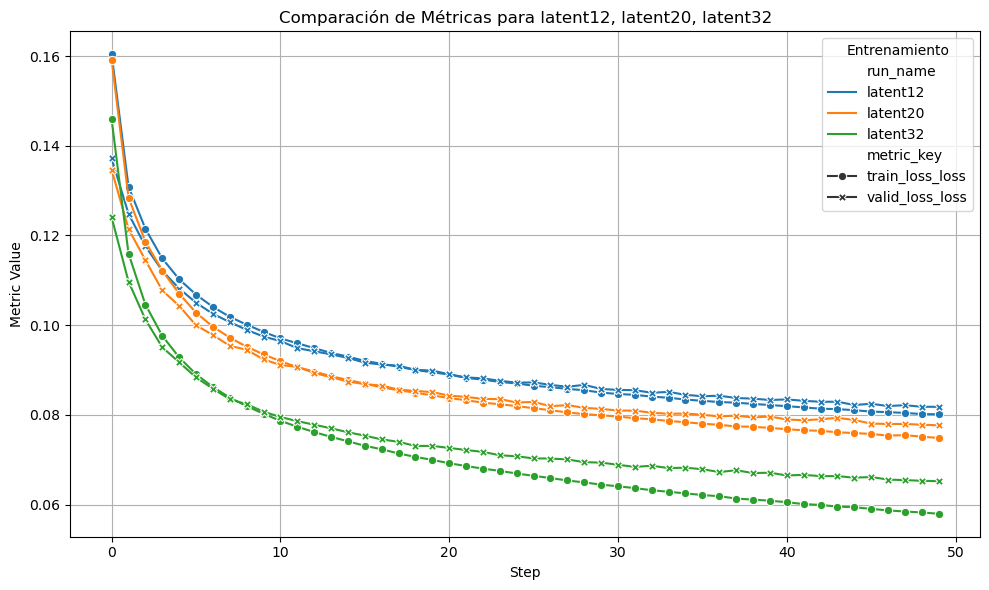

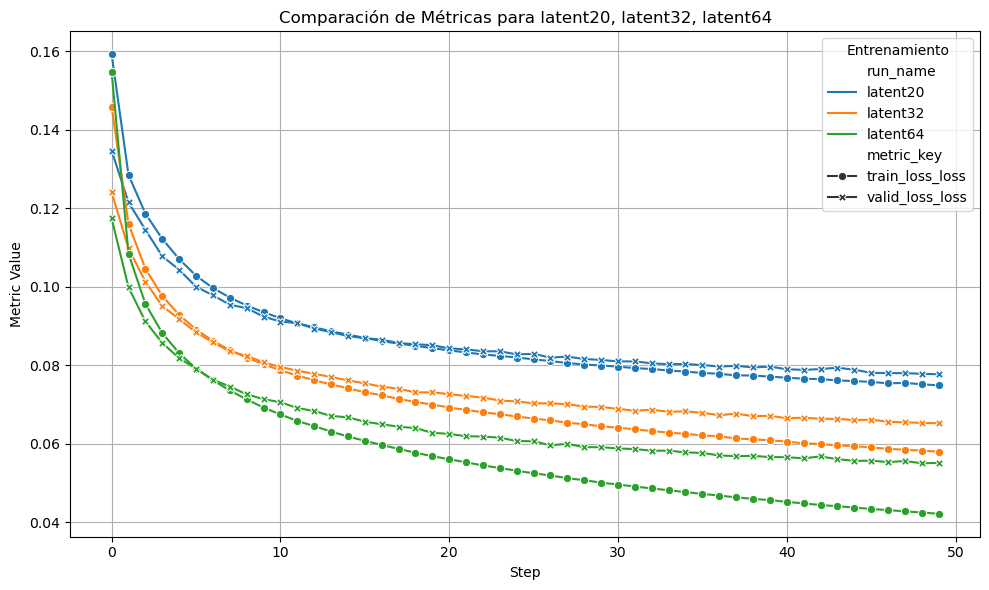

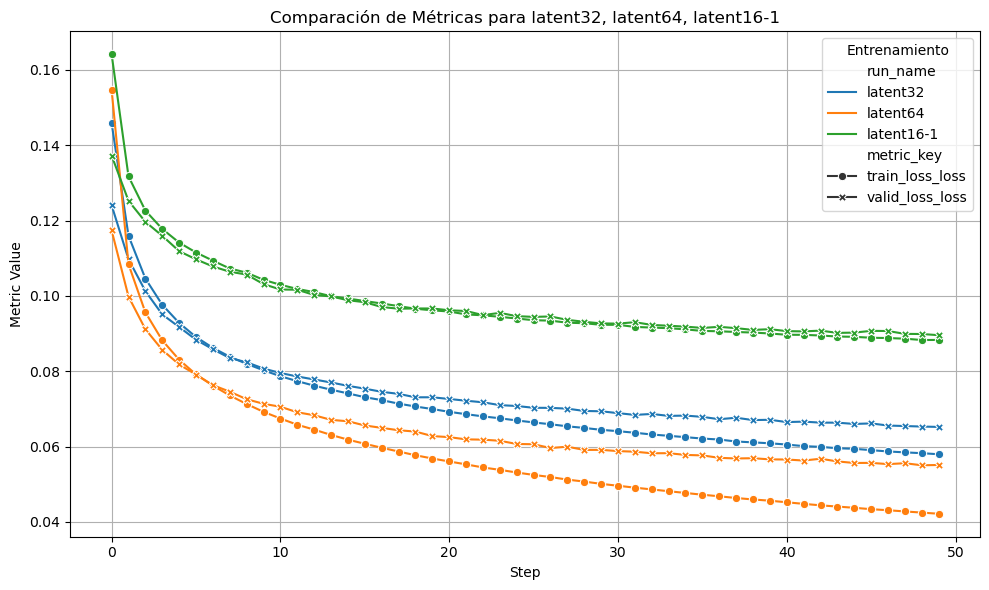

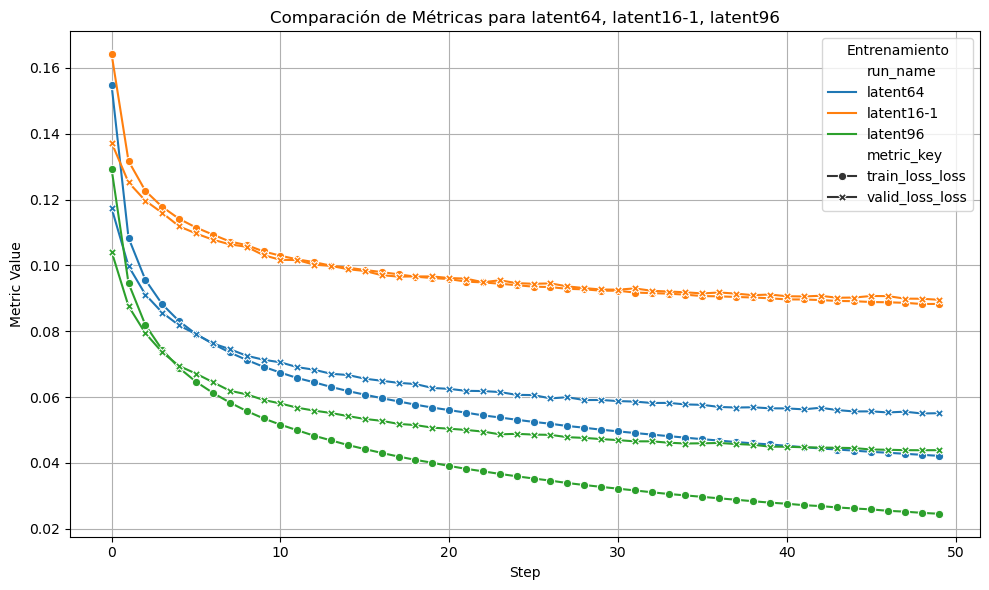

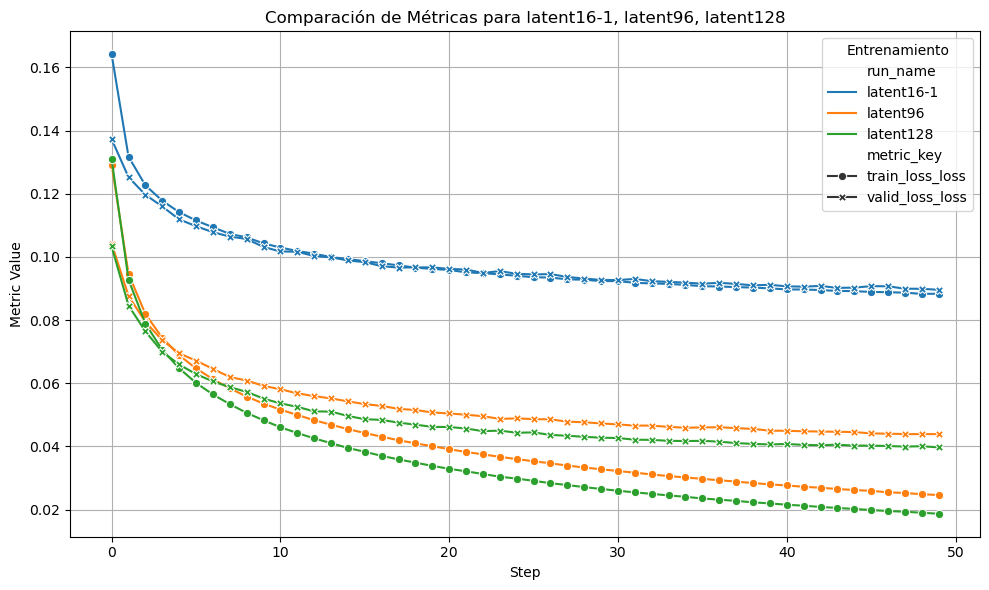

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Lista de nombres de run_name
run_names = df_.run_name.unique()

# Iterar por grupos de 3
for i in range(len(run_names) - 2):
    group = run_names[i:i + 3]
    
    # Filtrar el DataFrame para incluir solo los nombres en el grupo actual
    df_group = df_[df_['run_name'].isin(group)]
    
    # Crear el gráfico
    plt.figure(figsize=(10, 6))
    sns.lineplot(
        data=df_group,
        x='step',
        y='metric_value',
        hue='run_name',
        style='metric_key',
        markers=True,
        dashes=False,
        palette="tab10"
    )
    plt.title(f"Comparación de Métricas para {', '.join(group)}")
    plt.xlabel("Step")
    plt.ylabel("Metric Value")
    plt.legend(title="Entrenamiento")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [19]:
# Supongamos que tienes el DataFrame `df` con la tabla original
# Crear la tabla pivot
df_pivot = df.pivot(
    index=['run_name', 'step'],  # Columnas que se mantendrán como índices
    columns='metric_key',  # Columna cuyos valores se convierten en encabezados
    values='metric_value'  # Valores de las nuevas columnas
).reset_index()  # Reiniciar índices para obtener un DataFrame plano

# Visualizar la nueva tabla
display(df_pivot.head())


metric_key,run_name,step,train_Accuracy,train_Accuracy_seq,train_F1,train_Precision,train_Recall,train_ce_loss,train_loss,train_loss_Accuracy,...,train_loss_Recall,train_loss_ce_loss,train_loss_loss,valid_loss_Accuracy,valid_loss_Accuracy_seq,valid_loss_F1,valid_loss_Precision,valid_loss_Recall,valid_loss_ce_loss,valid_loss_loss
0,latent12,0,0.801301,0.0,0.736723,0.758430,0.801301,639.337077,0.160394,0.801301,...,0.801301,639.337077,0.160394,0.819462,0.0,0.766008,0.797278,0.819462,624.870662,0.137167
1,latent12,1,0.825815,0.0,0.780278,0.810565,0.825815,633.054854,0.130898,0.825815,...,0.825815,633.054854,0.130898,0.834170,0.0,0.794099,0.820061,0.834170,620.391801,0.124839
2,latent12,2,0.838987,0.0,0.805604,0.826604,0.838987,629.051546,0.121506,0.838987,...,0.838987,629.051546,0.121506,0.843699,0.0,0.809248,0.834227,0.843699,617.615674,0.117604
3,latent12,3,0.848303,0.0,0.820470,0.837800,0.848303,626.096045,0.114873,0.848303,...,0.848303,626.096045,0.114873,0.850780,0.0,0.823482,0.840514,0.850780,614.593171,0.112149
4,latent12,4,0.854784,0.0,0.830878,0.845741,0.854784,623.878154,0.110260,0.854784,...,0.854784,623.878154,0.110260,0.856883,0.0,0.830689,0.849909,0.856883,612.942363,0.108165


In [35]:
df_pivot.sample(5).to_clipboard()

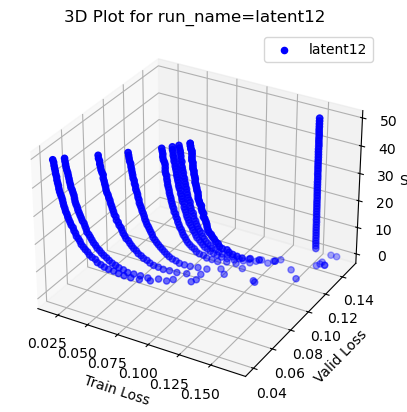

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

 
 

# Crear el gráfico 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Graficar los datos
ax.scatter(df_pivot["train_loss"], df_pivot["valid_loss_loss"], df_pivot["step"], c='blue', marker='o', label="latent12")

# Etiquetas
ax.set_xlabel("Train Loss")
ax.set_ylabel("Valid Loss")
ax.set_zlabel("Step")
ax.set_title("3D Plot for run_name=latent12")

# Mostrar gráfico
plt.legend()
plt.show()


In [29]:
# Crear un gráfico interactivo con botones para seleccionar run_name
fig = go.Figure()

# Agregar la línea para train_loss
fig.add_trace(go.Scatter(
    x=df_pivot["step"],
    y=df_pivot["train_loss"],
    mode='lines+markers',
    name='Train Loss (latent12)',
    line=dict(color='blue', width=2),
    marker=dict(size=5, color='blue'),
    visible=True
))

# Agregar la línea para valid_loss_loss
fig.add_trace(go.Scatter(
    x=df_pivot["step"],
    y=df_pivot["valid_loss_loss"],
    mode='lines+markers',
    name='Validation Loss (latent12)',
    line=dict(color='red', width=2),
    marker=dict(size=5, color='red'),
    visible=True
))

# Configurar botones para alternar entre mostrar y ocultar trazas
fig.update_layout(
    updatemenus=[
        dict(
            type="buttons",
            direction="right",
            x=0.1,
            y=1.15,
            showactive=True,
            buttons=[
                dict(label="Show All",
                     method="update",
                     args=[{"visible": [True, True]},
                           {"title": "All Metrics Shown"}]),
                dict(label="Hide All",
                     method="update",
                     args=[{"visible": [False, False]},
                           {"title": "Metrics Hidden"}])
            ]
        )
    ],
    title="Train vs Validation Loss with Selection Buttons",
    xaxis_title="Step",
    yaxis_title="Loss",
    template="plotly_white"
)

# Mostrar el gráfico
fig.show()


In [38]:
# Crear un gráfico interactivo con selección múltiple para comparar run_names específicos
fig = go.Figure()

# Iterar sobre cada run_name único y agregarlo como traza
unique_run_names = df_pivot["run_name"].unique()
colors = ['blue', 'red', 'green', 'purple', 'orange']

for i, run_name in enumerate(unique_run_names):
    df_subset = df_pivot[df_pivot["run_name"] == run_name]
    fig.add_trace(go.Scatter(
        x=df_subset["step"],
        y=df_subset["train_loss"],
        mode='lines+markers',
        name=f'Train Loss ({run_name})',
        line=dict(color=colors[i % len(colors)], width=2),
        marker=dict(size=5, color=colors[i % len(colors)])
    ))
    fig.add_trace(go.Scatter(
        x=df_subset["step"],
        y=df_subset["valid_loss_loss"],
        mode='lines+markers',
        name=f'Validation Loss ({run_name})',
        line=dict(dash='dot', color=colors[i % len(colors)], width=2),
        marker=dict(size=5, color=colors[i % len(colors)])
    ))

# Configurar el menú con checkboxes para selección múltiple
fig.update_layout(
    updatemenus=[
        dict(
            type="buttons",
            showactive=True,
            direction="down",
            x=1.1,
            y=0.5,
            buttons=[
                dict(label=run_name,
                     method="update",
                     args=[
                         {"visible": [run_name in trace.name for trace in fig.data]}
                     ])
                for run_name in unique_run_names
            ] + [
                dict(label="Show All",
                     method="update",
                     args=[{"visible": [True] * len(fig.data)}]),
                dict(label="Hide All",
                     method="update",
                     args=[{"visible": [False] * len(fig.data)}])
            ]
        )
    ],
    title="Train vs Validation Loss with Custom Selection for Run Names",
    xaxis_title="Step",
    yaxis_title="Loss",
    template="plotly_white"
)

# Mostrar el gráfico
fig.show()
